In [1]:
import torch
from tqdm import tqdm

In [2]:
# === デバイス設定 ===
# CUDA (GPU) が利用可能ならGPUを、そうでなければCPUを使用
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

# === ハイパーパラメータ ===
s_0 = 100.0  # 初期細胞密度（float型を使用）

l_A = 1.0  # 面積エネルギー項の係数λ_A
l_L = 1.0  # 周囲長エネルギー項の係数λ_L (注意: TF版のcalc_cpm_percentでは未使用だった)
A_0 = 150.0  # 目標細胞面積 A_0
L_0 = 42.0  # 目標細胞周囲長 L_0 (注意: TF版のcalc_cpm_percentでは未使用だった)

T = 1.0  # 温度パラメータ T (ボルツマン分布の計算に使用)


GPUを利用します: NVIDIA H100 PCIe


In [3]:
from CPM import *
from CPM_Image import *

GPUを利用します: NVIDIA H100 PCIe


初期マップ（中央部分）:


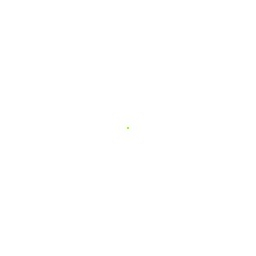

動画を cpm_torch_jp.mp4 に記録します。
map shape  torch.Size([256, 256, 3])


エポック:   0%|          | 0/200 [00:00<?, ?it/s]

エポック 1/200
現在のマップ（中央部分）:


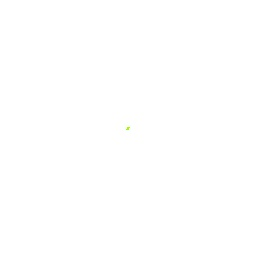

エポック:   0%|          | 1/200 [00:00<01:13,  2.70it/s]

面積
tensor([6.5528e+04, 8.0000e+00], device='cuda:0')
周囲長
tensor([14., 14.], device='cuda:0')
True
フレーム 1 の動画への追加中にエラー: moviepy.video.io.ffmpeg_writer.FFMPEG_VideoWriter() got multiple values for keyword argument 'filename'


エポック 2/200
現在のマップ（中央部分）:


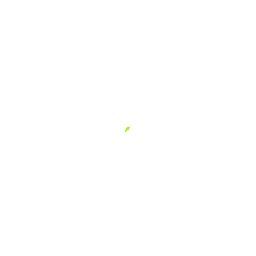

面積
tensor([6.5524e+04, 1.2000e+01], device='cuda:0')
周囲長
tensor([20., 20.], device='cuda:0')
False


エポック 3/200
現在のマップ（中央部分）:


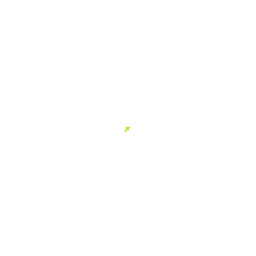

面積
tensor([6.5523e+04, 1.3000e+01], device='cuda:0')
周囲長
tensor([20., 20.], device='cuda:0')
False


エポック 4/200
現在のマップ（中央部分）:


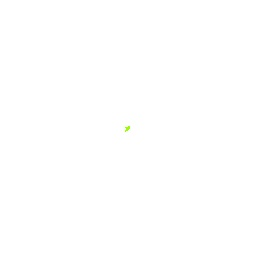

面積
tensor([6.5518e+04, 1.8000e+01], device='cuda:0')
周囲長
tensor([24., 24.], device='cuda:0')
False


エポック 5/200
現在のマップ（中央部分）:


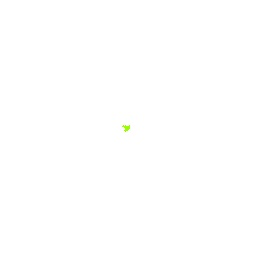

エポック:   2%|▎         | 5/200 [00:00<00:15, 12.93it/s]

面積
tensor([6.5505e+04, 3.1000e+01], device='cuda:0')
周囲長
tensor([36., 36.], device='cuda:0')
False


エポック 6/200
現在のマップ（中央部分）:


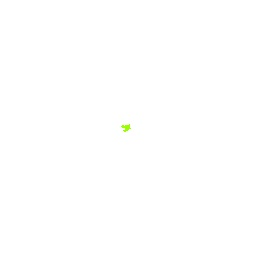

面積
tensor([6.5494e+04, 4.2000e+01], device='cuda:0')
周囲長
tensor([42., 42.], device='cuda:0')
False


エポック 7/200
現在のマップ（中央部分）:


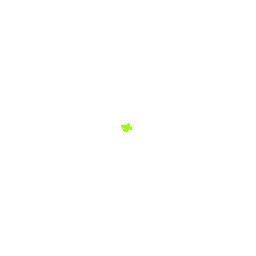

面積
tensor([6.5478e+04, 5.8000e+01], device='cuda:0')
周囲長
tensor([46., 46.], device='cuda:0')
False


エポック 8/200
現在のマップ（中央部分）:


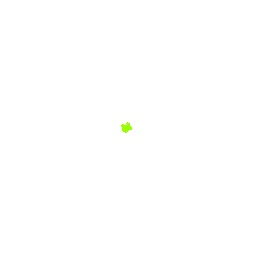

面積
tensor([65463.,    73.], device='cuda:0')
周囲長
tensor([48., 48.], device='cuda:0')
False


エポック 9/200
現在のマップ（中央部分）:


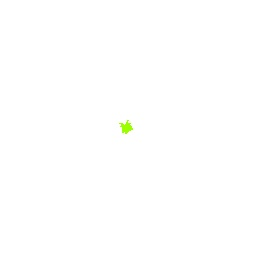

エポック:   4%|▍         | 9/200 [00:00<00:09, 20.48it/s]

面積
tensor([65437.,    99.], device='cuda:0')
周囲長
tensor([68., 68.], device='cuda:0')
False


エポック 10/200
現在のマップ（中央部分）:


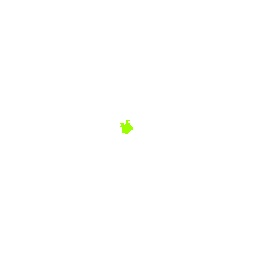

面積
tensor([65430.,   106.], device='cuda:0')
周囲長
tensor([64., 64.], device='cuda:0')
False


エポック 11/200
現在のマップ（中央部分）:


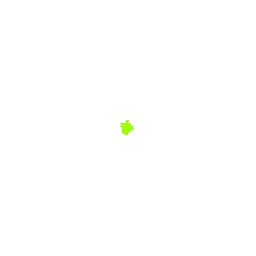

面積
tensor([65419.,   117.], device='cuda:0')
周囲長
tensor([62., 62.], device='cuda:0')
False


エポック 12/200
現在のマップ（中央部分）:


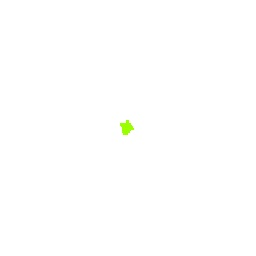

面積
tensor([65411.,   125.], device='cuda:0')
周囲長
tensor([58., 58.], device='cuda:0')
False


エポック 13/200
現在のマップ（中央部分）:


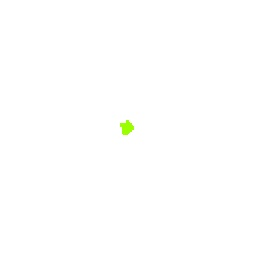

面積

エポック:   6%|▋         | 13/200 [00:00<00:09, 19.19it/s]


tensor([65399.,   137.], device='cuda:0')
周囲長
tensor([58., 58.], device='cuda:0')
False


エポック 14/200
現在のマップ（中央部分）:


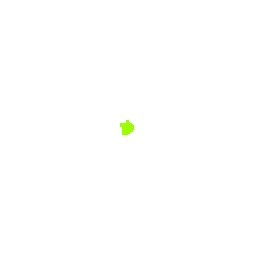

面積
tensor([65392.,   144.], device='cuda:0')
周囲長
tensor([58., 58.], device='cuda:0')
False


エポック 15/200
現在のマップ（中央部分）:


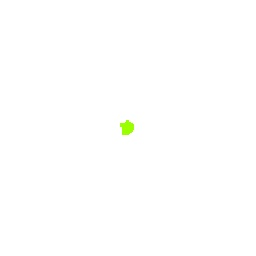

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([58., 58.], device='cuda:0')
False


エポック 16/200
現在のマップ（中央部分）:


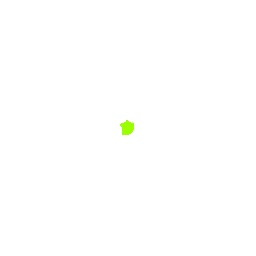

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([58., 58.], device='cuda:0')
False


エポック 17/200
現在のマップ（中央部分）:


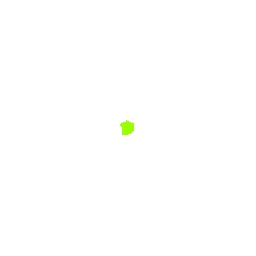

エポック:   8%|▊         | 17/200 [00:00<00:07, 24.00it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([58., 58.], device='cuda:0')
False


エポック 18/200
現在のマップ（中央部分）:


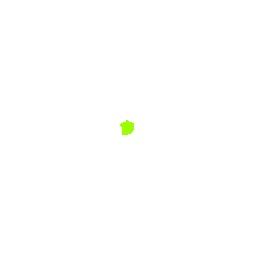

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([58., 58.], device='cuda:0')
False


エポック 19/200
現在のマップ（中央部分）:


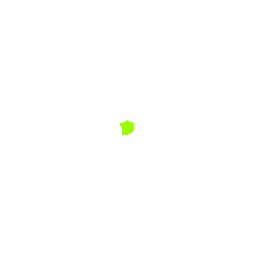

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([58., 58.], device='cuda:0')
False


エポック 20/200
現在のマップ（中央部分）:


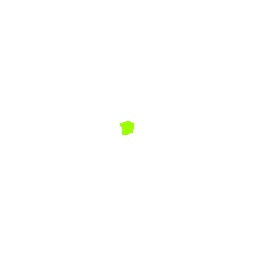

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([56., 56.], device='cuda:0')
False


エポック 21/200
現在のマップ（中央部分）:


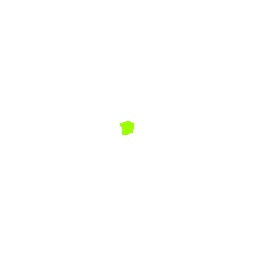

エポック:  10%|█         | 21/200 [00:01<00:06, 27.79it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([56., 56.], device='cuda:0')
False


エポック 22/200
現在のマップ（中央部分）:


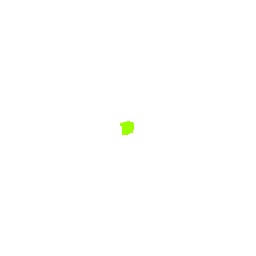

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([56., 56.], device='cuda:0')
False


エポック 23/200
現在のマップ（中央部分）:


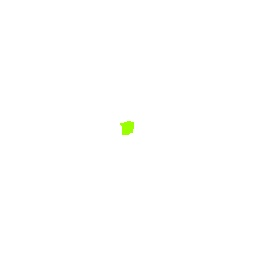

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([56., 56.], device='cuda:0')
False


エポック 24/200
現在のマップ（中央部分）:


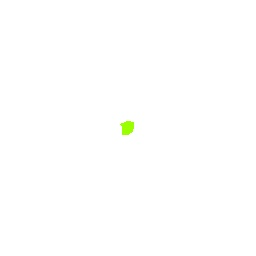

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([56., 56.], device='cuda:0')
False


エポック 25/200
現在のマップ（中央部分）:


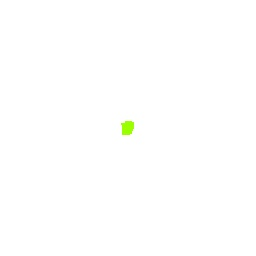

エポック:  12%|█▎        | 25/200 [00:01<00:05, 30.82it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 26/200
現在のマップ（中央部分）:


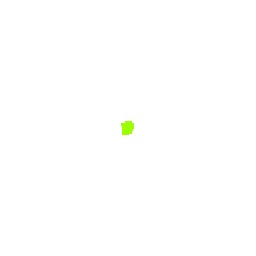

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 27/200
現在のマップ（中央部分）:


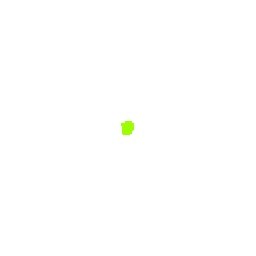

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 28/200
現在のマップ（中央部分）:


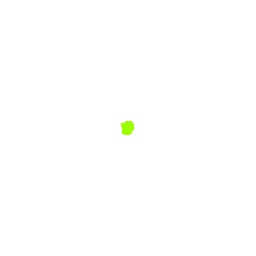

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 29/200
現在のマップ（中央部分）:


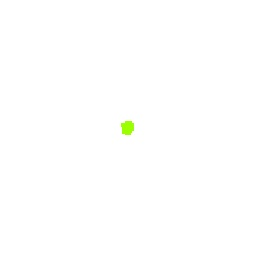

エポック:  14%|█▍        | 29/200 [00:01<00:05, 32.72it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 30/200
現在のマップ（中央部分）:


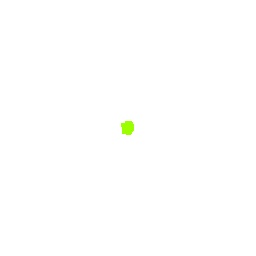

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 31/200
現在のマップ（中央部分）:


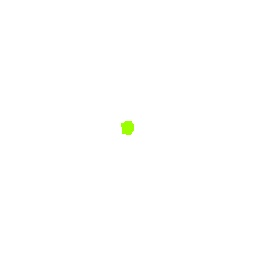

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 32/200
現在のマップ（中央部分）:


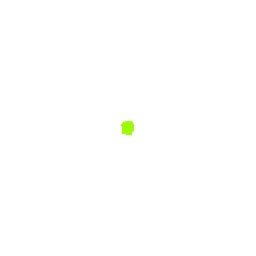

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 33/200
現在のマップ（中央部分）:


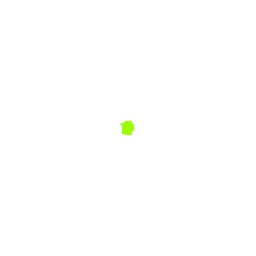

エポック:  16%|█▋        | 33/200 [00:01<00:04, 34.26it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 34/200
現在のマップ（中央部分）:


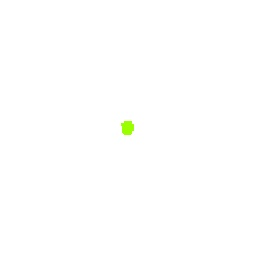

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 35/200
現在のマップ（中央部分）:


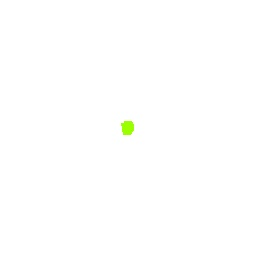

面積
tensor([65384.,   152.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 36/200
現在のマップ（中央部分）:


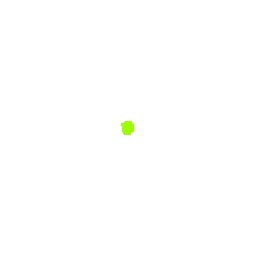

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 37/200
現在のマップ（中央部分）:


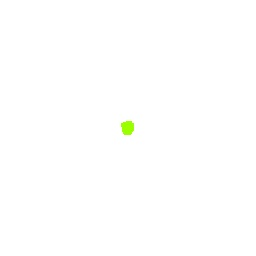

エポック:  18%|█▊        | 37/200 [00:01<00:04, 35.08it/s]

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 38/200
現在のマップ（中央部分）:


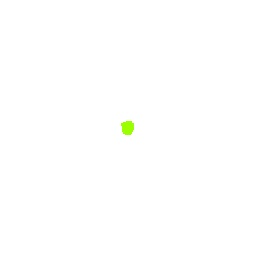

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 39/200
現在のマップ（中央部分）:


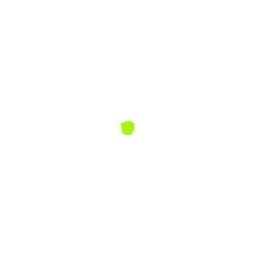

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 40/200
現在のマップ（中央部分）:


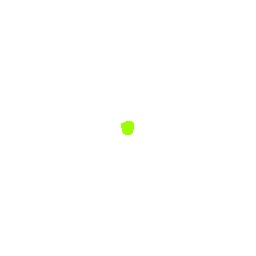

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 41/200
現在のマップ（中央部分）:


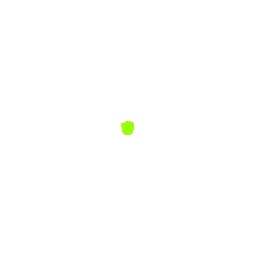

エポック:  20%|██        | 41/200 [00:01<00:04, 35.52it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 42/200
現在のマップ（中央部分）:


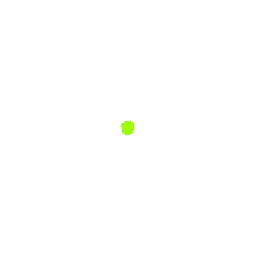

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 43/200
現在のマップ（中央部分）:


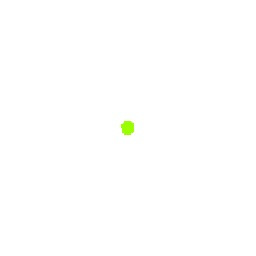

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 44/200
現在のマップ（中央部分）:


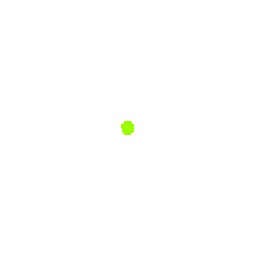

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 45/200
現在のマップ（中央部分）:


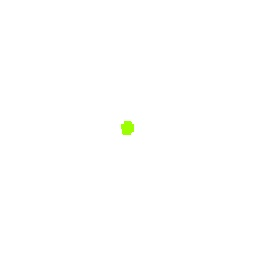

エポック:  22%|██▎       | 45/200 [00:01<00:04, 36.03it/s]

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 46/200
現在のマップ（中央部分）:


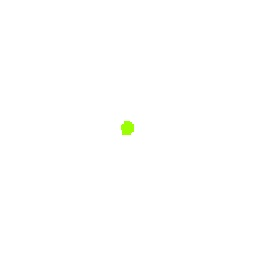

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 47/200
現在のマップ（中央部分）:


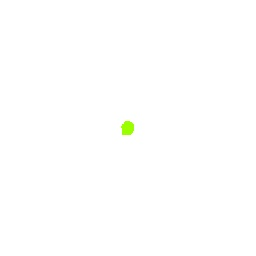

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 48/200
現在のマップ（中央部分）:


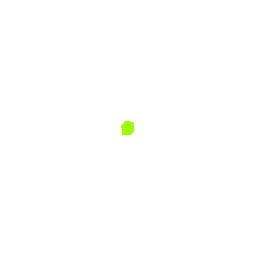

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([54., 54.], device='cuda:0')
False


エポック 49/200
現在のマップ（中央部分）:


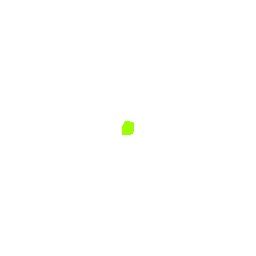

エポック:  24%|██▍       | 49/200 [00:01<00:05, 30.06it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 50/200
現在のマップ（中央部分）:


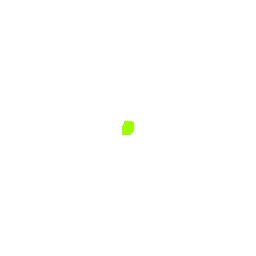

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 51/200
現在のマップ（中央部分）:


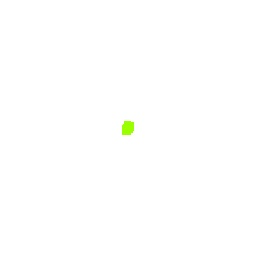

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 52/200
現在のマップ（中央部分）:


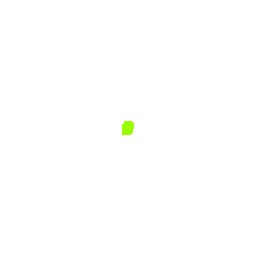

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 53/200
現在のマップ（中央部分）:


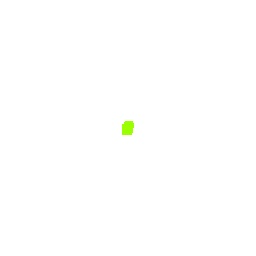

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 54/200
現在のマップ（中央部分）:


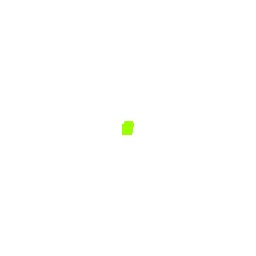

エポック:  27%|██▋       | 54/200 [00:01<00:04, 32.91it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 55/200
現在のマップ（中央部分）:


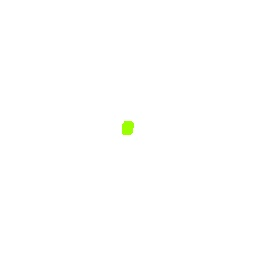

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 56/200
現在のマップ（中央部分）:


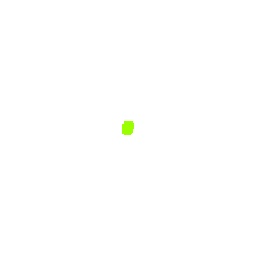

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 57/200
現在のマップ（中央部分）:


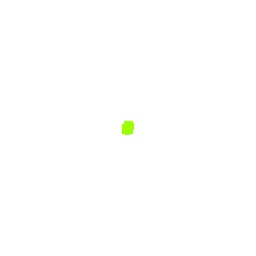

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 58/200
現在のマップ（中央部分）:


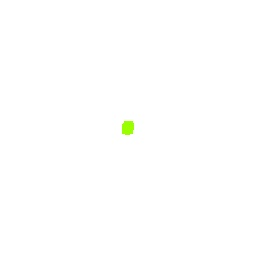

エポック:  29%|██▉       | 58/200 [00:02<00:04, 33.75it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 59/200
現在のマップ（中央部分）:


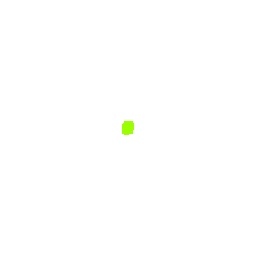

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 60/200
現在のマップ（中央部分）:


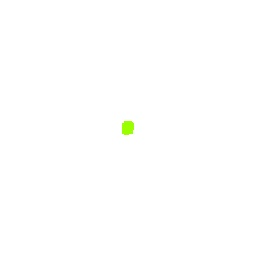

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 61/200
現在のマップ（中央部分）:


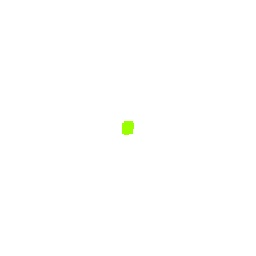

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 62/200
現在のマップ（中央部分）:


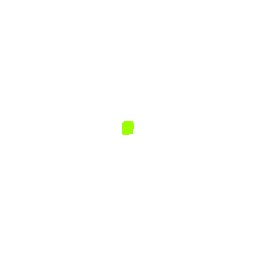

エポック:  31%|███       | 62/200 [00:02<00:03, 34.65it/s]

面積
tensor([65384.,   152.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 63/200
現在のマップ（中央部分）:


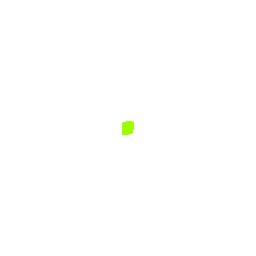

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 64/200
現在のマップ（中央部分）:


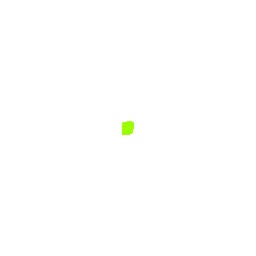

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 65/200
現在のマップ（中央部分）:


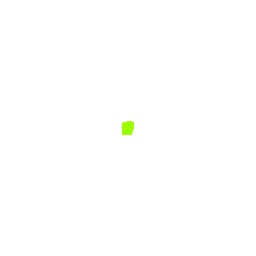

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 66/200
現在のマップ（中央部分）:


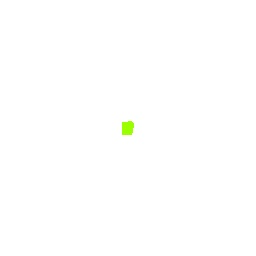

エポック:  33%|███▎      | 66/200 [00:02<00:03, 35.39it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 67/200
現在のマップ（中央部分）:


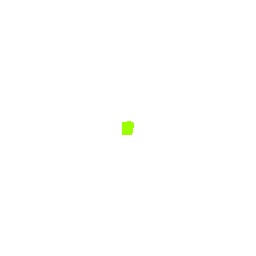

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 68/200
現在のマップ（中央部分）:


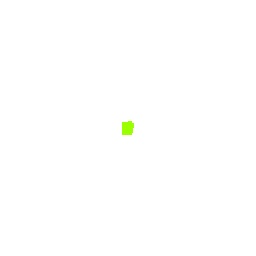

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 69/200
現在のマップ（中央部分）:


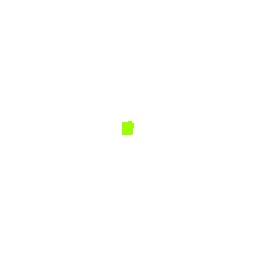

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 70/200
現在のマップ（中央部分）:


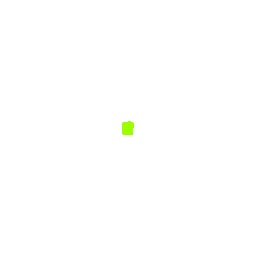

エポック:  35%|███▌      | 70/200 [00:02<00:03, 36.41it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 71/200
現在のマップ（中央部分）:


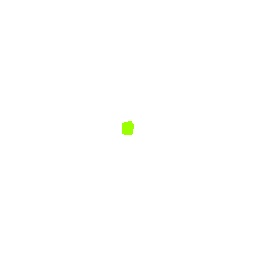

面積
tensor([65390.,   146.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 72/200
現在のマップ（中央部分）:


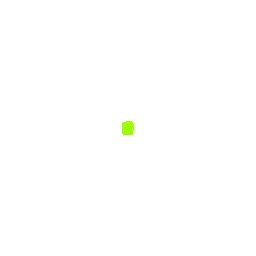

面積
tensor([65383.,   153.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 73/200
現在のマップ（中央部分）:


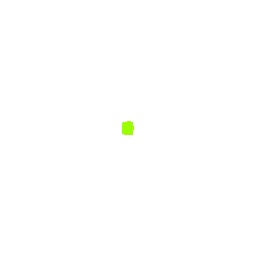

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 74/200
現在のマップ（中央部分）:


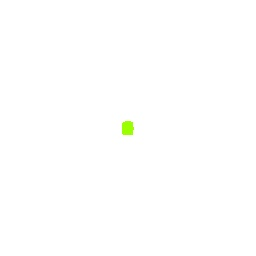

エポック:  37%|███▋      | 74/200 [00:02<00:03, 36.83it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 75/200
現在のマップ（中央部分）:


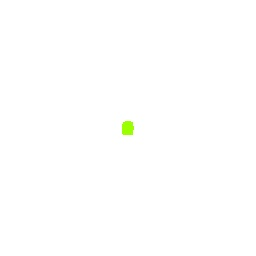

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 76/200
現在のマップ（中央部分）:


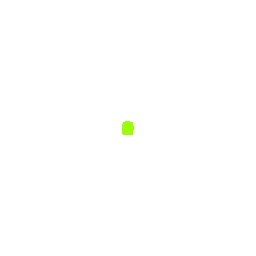

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 77/200
現在のマップ（中央部分）:


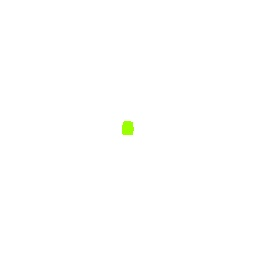

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 78/200
現在のマップ（中央部分）:


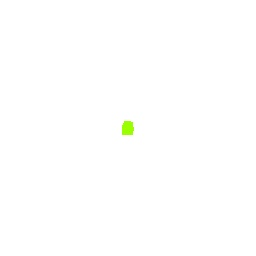

エポック:  39%|███▉      | 78/200 [00:02<00:03, 37.24it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 79/200
現在のマップ（中央部分）:


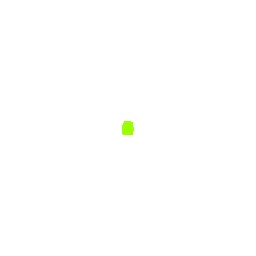

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 80/200
現在のマップ（中央部分）:


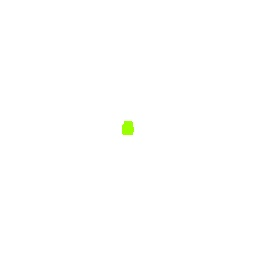

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 81/200
現在のマップ（中央部分）:


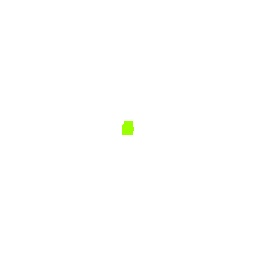

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 82/200
現在のマップ（中央部分）:


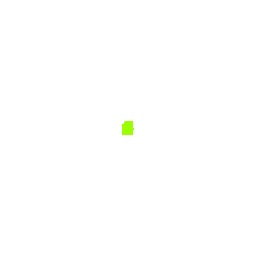

エポック:  41%|████      | 82/200 [00:02<00:03, 36.87it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 83/200
現在のマップ（中央部分）:


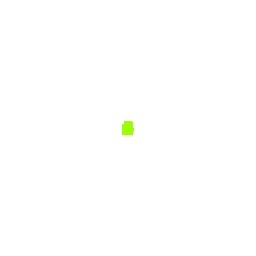

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 84/200
現在のマップ（中央部分）:


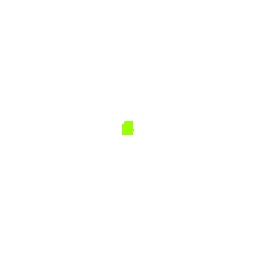

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([52., 52.], device='cuda:0')
False


エポック 85/200
現在のマップ（中央部分）:


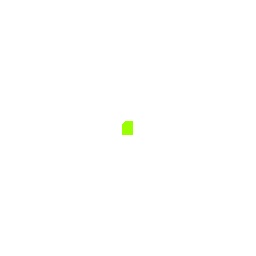

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 86/200
現在のマップ（中央部分）:


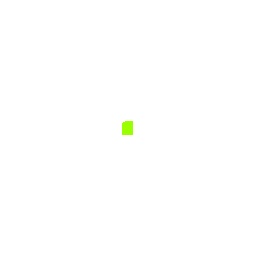

エポック:  43%|████▎     | 86/200 [00:02<00:03, 37.53it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 87/200
現在のマップ（中央部分）:


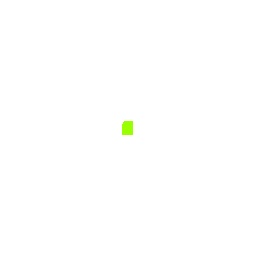

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 88/200
現在のマップ（中央部分）:


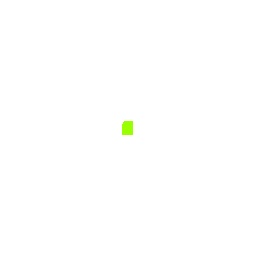

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 89/200
現在のマップ（中央部分）:


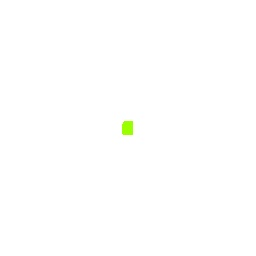

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 90/200
現在のマップ（中央部分）:


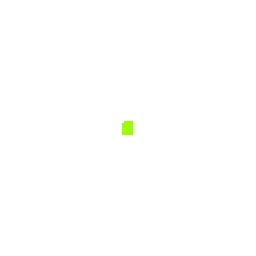

エポック:  45%|████▌     | 90/200 [00:02<00:02, 37.39it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 91/200
現在のマップ（中央部分）:


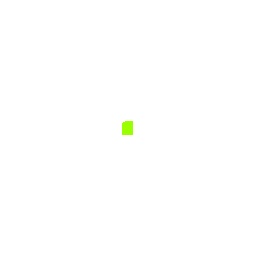

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 92/200
現在のマップ（中央部分）:


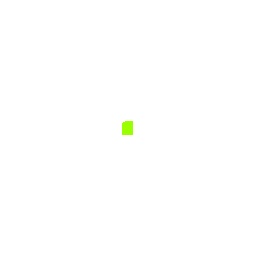

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 93/200
現在のマップ（中央部分）:


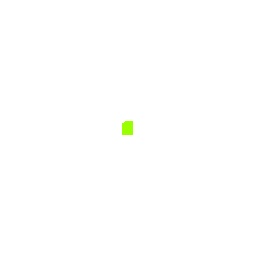

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 94/200
現在のマップ（中央部分）:


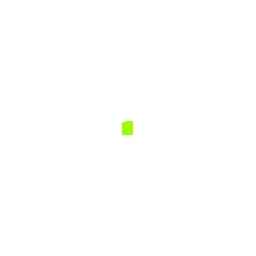

エポック:  47%|████▋     | 94/200 [00:03<00:02, 37.41it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 95/200
現在のマップ（中央部分）:


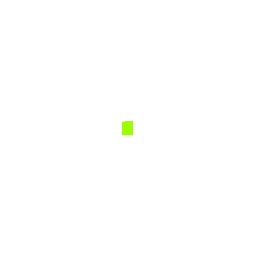

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 96/200
現在のマップ（中央部分）:


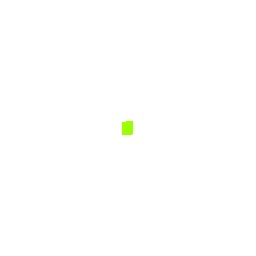

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 97/200
現在のマップ（中央部分）:


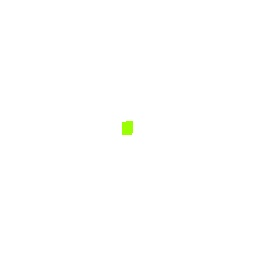

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 98/200
現在のマップ（中央部分）:


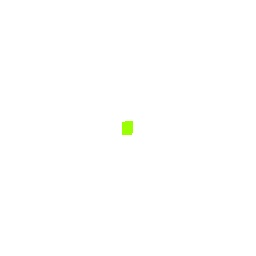

エポック:  49%|████▉     | 98/200 [00:03<00:02, 36.81it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 99/200
現在のマップ（中央部分）:


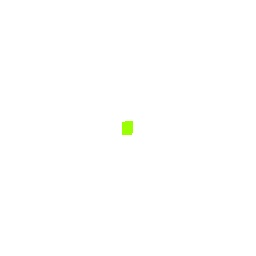

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 100/200
現在のマップ（中央部分）:


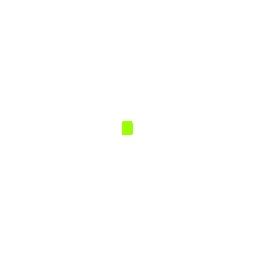

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 101/200
現在のマップ（中央部分）:


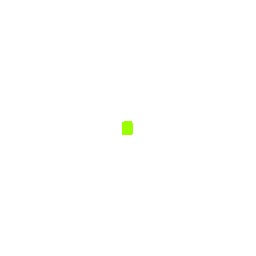

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 102/200
現在のマップ（中央部分）:


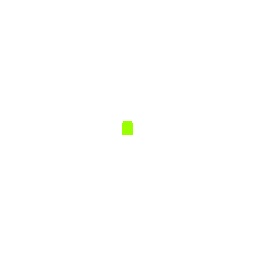

エポック:  51%|█████     | 102/200 [00:03<00:02, 35.78it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 103/200
現在のマップ（中央部分）:


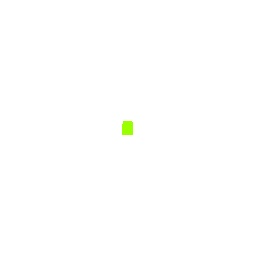

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 104/200
現在のマップ（中央部分）:


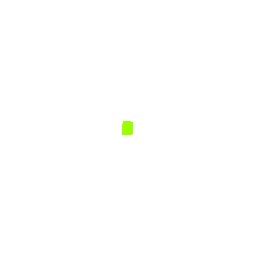

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 105/200
現在のマップ（中央部分）:


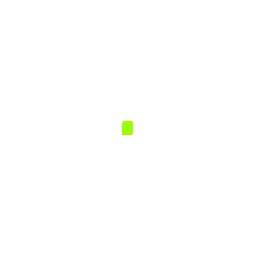

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 106/200
現在のマップ（中央部分）:


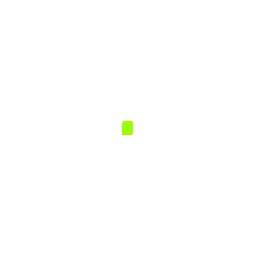

エポック:  53%|█████▎    | 106/200 [00:03<00:02, 36.61it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 107/200
現在のマップ（中央部分）:


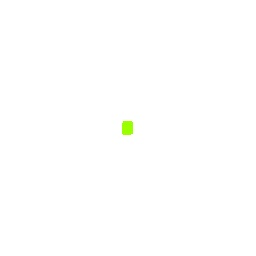

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 108/200
現在のマップ（中央部分）:


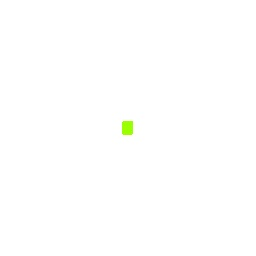

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 109/200
現在のマップ（中央部分）:


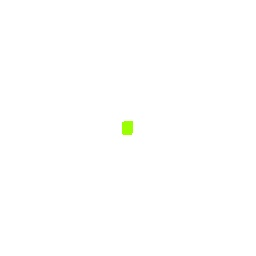

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 110/200
現在のマップ（中央部分）:


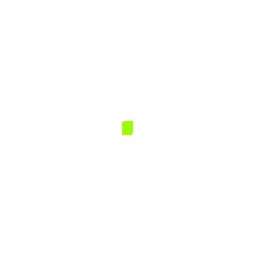

エポック:  55%|█████▌    | 110/200 [00:03<00:02, 36.39it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 111/200
現在のマップ（中央部分）:


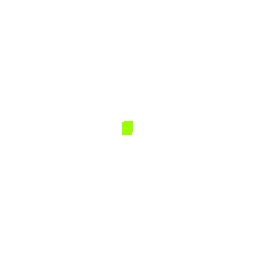

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 112/200
現在のマップ（中央部分）:


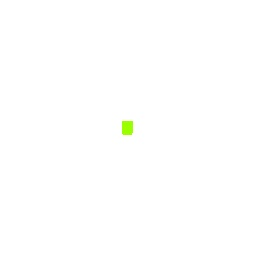

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 113/200
現在のマップ（中央部分）:


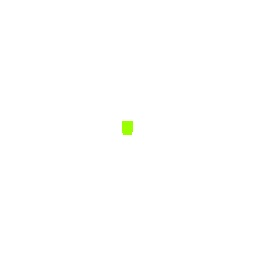

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 114/200
現在のマップ（中央部分）:


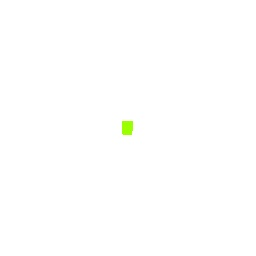

エポック:  57%|█████▋    | 114/200 [00:03<00:02, 36.58it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 115/200
現在のマップ（中央部分）:


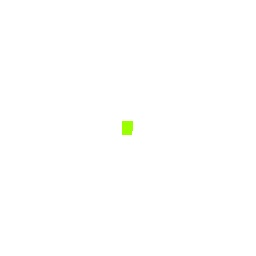

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 116/200
現在のマップ（中央部分）:


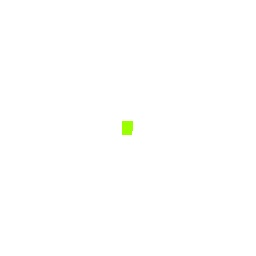

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 117/200
現在のマップ（中央部分）:


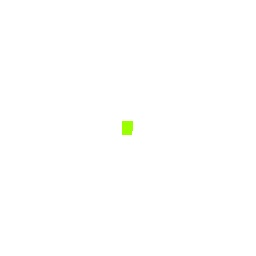

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 118/200
現在のマップ（中央部分）:


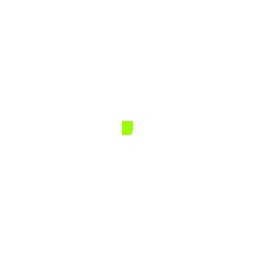

エポック:  59%|█████▉    | 118/200 [00:03<00:02, 35.86it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 119/200
現在のマップ（中央部分）:


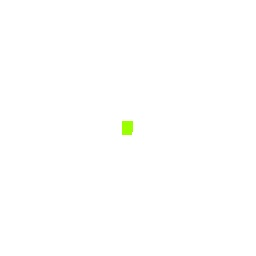

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 120/200
現在のマップ（中央部分）:


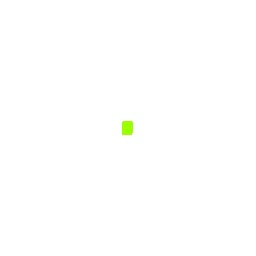

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 121/200
現在のマップ（中央部分）:


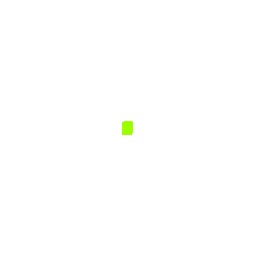

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 122/200
現在のマップ（中央部分）:


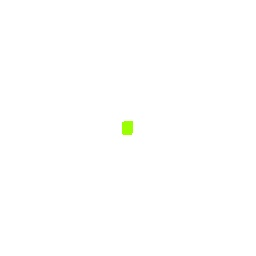

面積
tensor([65387.,   149.], device='cuda:0')
周囲長


エポック:  61%|██████    | 122/200 [00:03<00:02, 36.38it/s]

tensor([50., 50.], device='cuda:0')
False


エポック 123/200
現在のマップ（中央部分）:


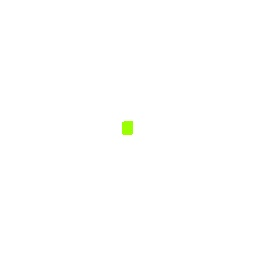

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 124/200
現在のマップ（中央部分）:


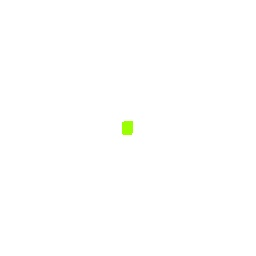

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 125/200
現在のマップ（中央部分）:


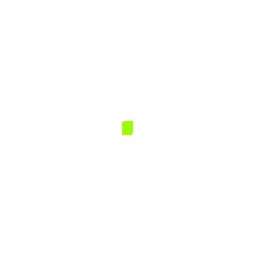

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 126/200
現在のマップ（中央部分）:


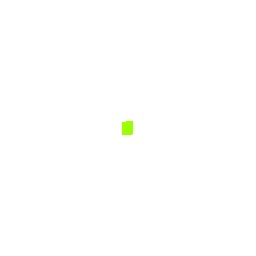

エポック:  63%|██████▎   | 126/200 [00:04<00:04, 17.05it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 127/200
現在のマップ（中央部分）:


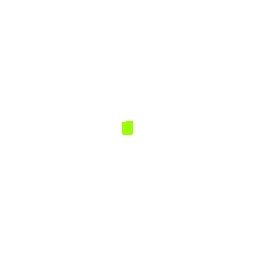

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 128/200
現在のマップ（中央部分）:


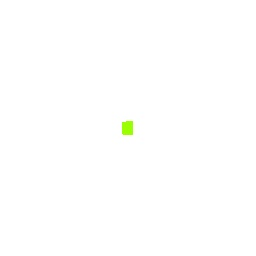

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 129/200
現在のマップ（中央部分）:


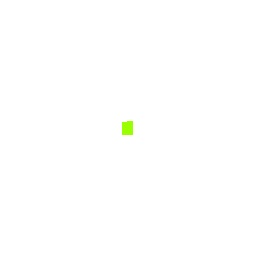

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 130/200
現在のマップ（中央部分）:


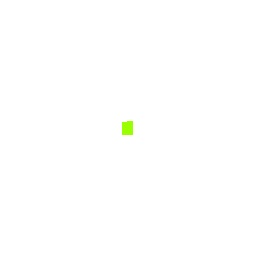

エポック:  65%|██████▌   | 130/200 [00:04<00:03, 20.39it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 131/200
現在のマップ（中央部分）:


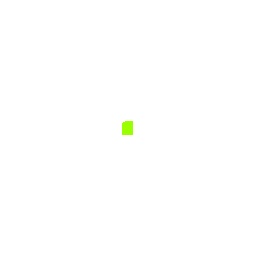

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 132/200
現在のマップ（中央部分）:


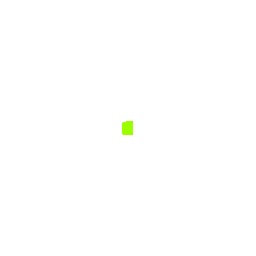

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 133/200
現在のマップ（中央部分）:


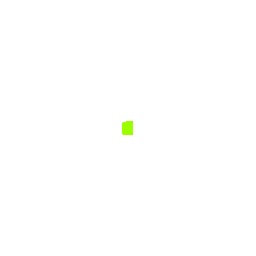

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 134/200
現在のマップ（中央部分）:


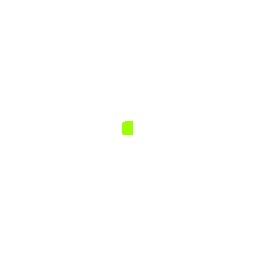

エポック:  67%|██████▋   | 134/200 [00:04<00:02, 23.29it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 135/200
現在のマップ（中央部分）:


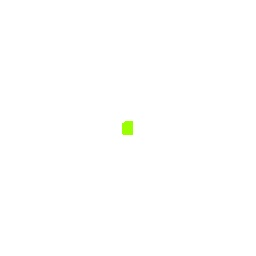

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 136/200
現在のマップ（中央部分）:


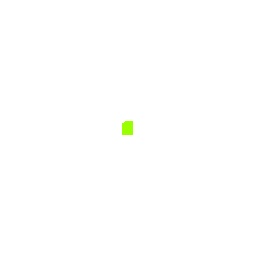

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 137/200
現在のマップ（中央部分）:


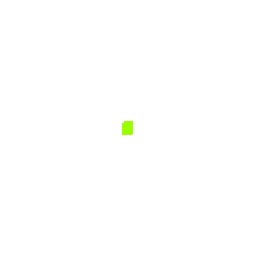

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 138/200
現在のマップ（中央部分）:


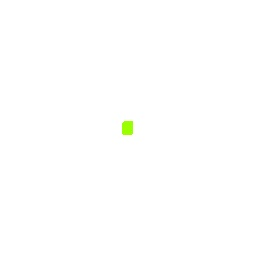

エポック:  69%|██████▉   | 138/200 [00:04<00:02, 25.42it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 139/200
現在のマップ（中央部分）:


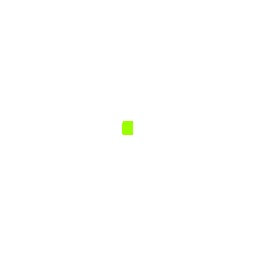

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 140/200
現在のマップ（中央部分）:


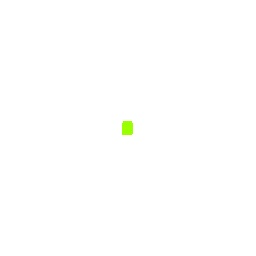

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 141/200
現在のマップ（中央部分）:


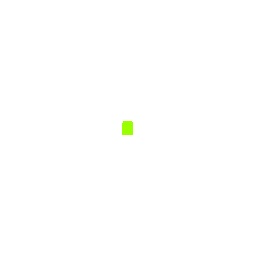

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 142/200
現在のマップ（中央部分）:


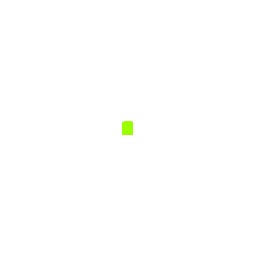

エポック:  71%|███████   | 142/200 [00:04<00:02, 27.50it/s]

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 143/200
現在のマップ（中央部分）:


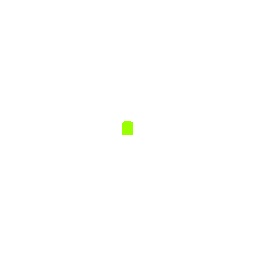

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 144/200
現在のマップ（中央部分）:


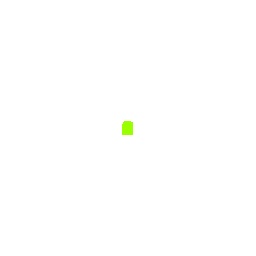

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 145/200
現在のマップ（中央部分）:


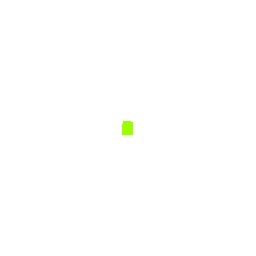

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 146/200
現在のマップ（中央部分）:


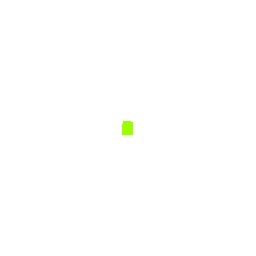

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック:  73%|███████▎  | 146/200 [00:04<00:01, 29.48it/s]

エポック 147/200
現在のマップ（中央部分）:


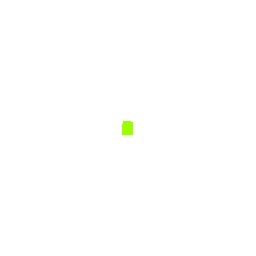

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 148/200
現在のマップ（中央部分）:


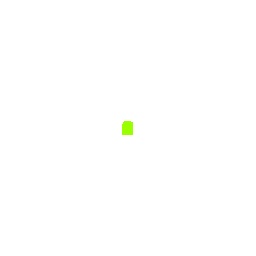

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 149/200
現在のマップ（中央部分）:


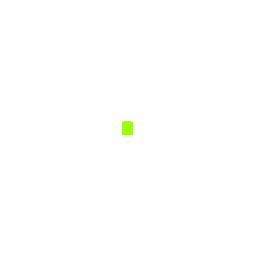

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 150/200
現在のマップ（中央部分）:


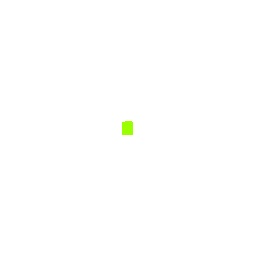

エポック:  75%|███████▌  | 150/200 [00:05<00:01, 30.83it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 151/200
現在のマップ（中央部分）:


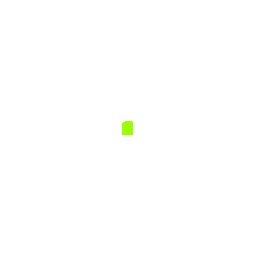

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 152/200
現在のマップ（中央部分）:


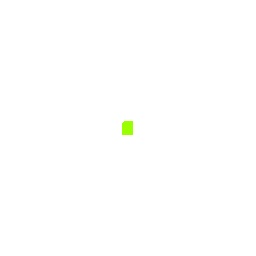

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 153/200
現在のマップ（中央部分）:


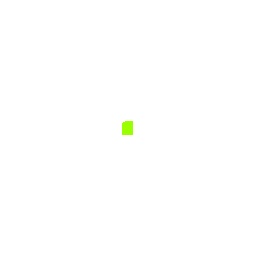

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 154/200
現在のマップ（中央部分）:


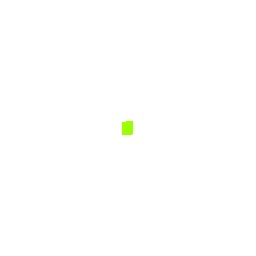

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック:  77%|███████▋  | 154/200 [00:05<00:01, 32.46it/s]

エポック 155/200
現在のマップ（中央部分）:


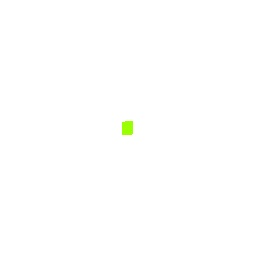

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 156/200
現在のマップ（中央部分）:


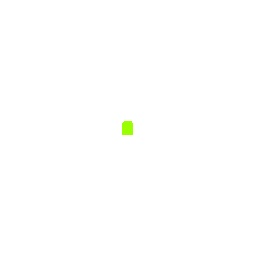

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 157/200
現在のマップ（中央部分）:


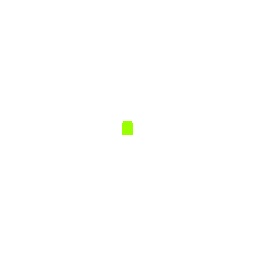

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 158/200
現在のマップ（中央部分）:


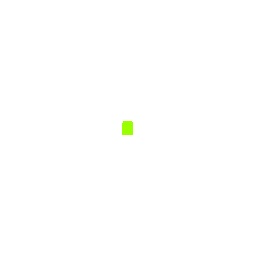

エポック:  79%|███████▉  | 158/200 [00:05<00:01, 32.71it/s]

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 159/200
現在のマップ（中央部分）:


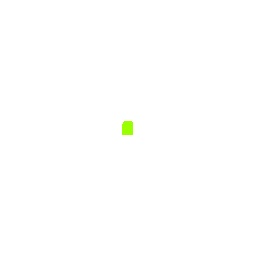

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 160/200
現在のマップ（中央部分）:


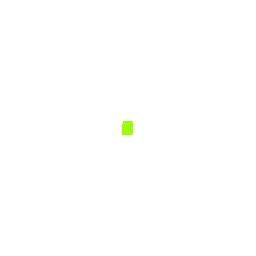

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 161/200
現在のマップ（中央部分）:


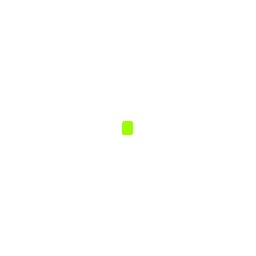

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 162/200
現在のマップ（中央部分）:


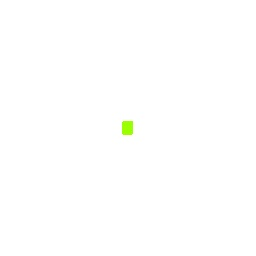

エポック:  81%|████████  | 162/200 [00:05<00:01, 34.44it/s]

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 163/200
現在のマップ（中央部分）:


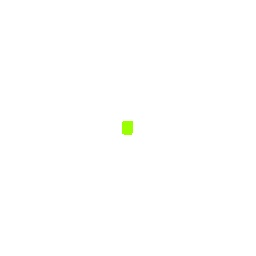

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 164/200
現在のマップ（中央部分）:


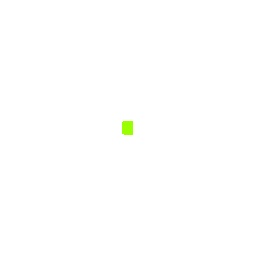

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 165/200
現在のマップ（中央部分）:


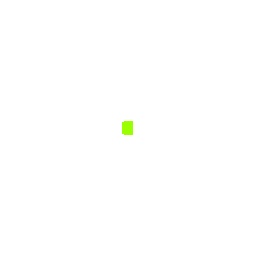

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 166/200
現在のマップ（中央部分）:


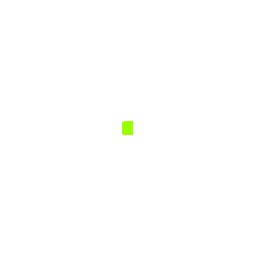

エポック:  83%|████████▎ | 166/200 [00:05<00:01, 32.42it/s]

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 167/200
現在のマップ（中央部分）:


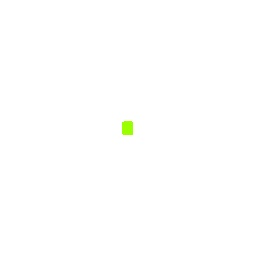

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 168/200
現在のマップ（中央部分）:


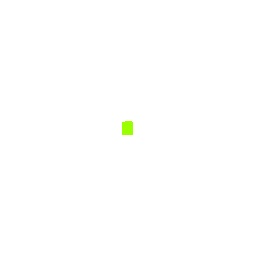

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 169/200
現在のマップ（中央部分）:


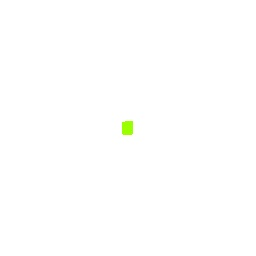

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 170/200
現在のマップ（中央部分）:


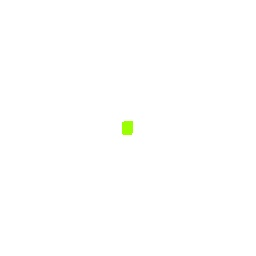

エポック:  85%|████████▌ | 170/200 [00:05<00:00, 33.51it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 171/200
現在のマップ（中央部分）:


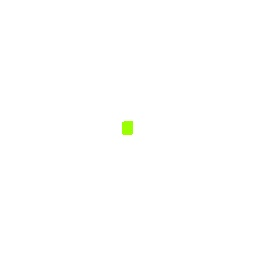

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 172/200
現在のマップ（中央部分）:


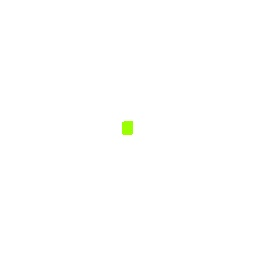

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 173/200
現在のマップ（中央部分）:


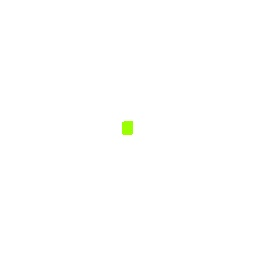

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 174/200
現在のマップ（中央部分）:


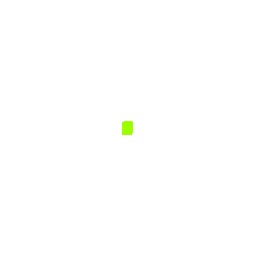

エポック:  87%|████████▋ | 174/200 [00:05<00:00, 33.48it/s]

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 175/200
現在のマップ（中央部分）:


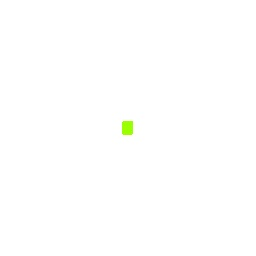

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 176/200
現在のマップ（中央部分）:


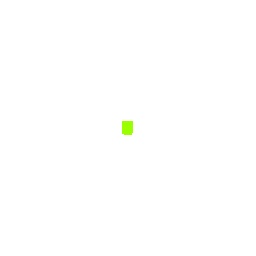

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 177/200
現在のマップ（中央部分）:


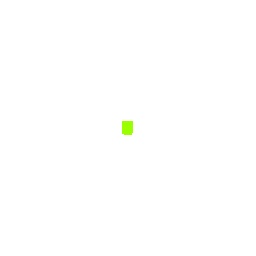

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 178/200
現在のマップ（中央部分）:


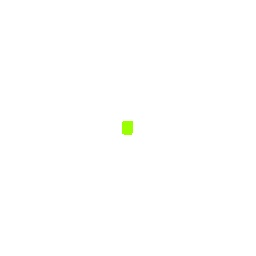

面積
tensor([65387.,   149.], device='cuda:0')
周囲長


エポック:  89%|████████▉ | 178/200 [00:05<00:00, 33.57it/s]

tensor([50., 50.], device='cuda:0')
False


エポック 179/200
現在のマップ（中央部分）:


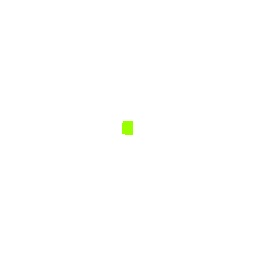

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 180/200
現在のマップ（中央部分）:


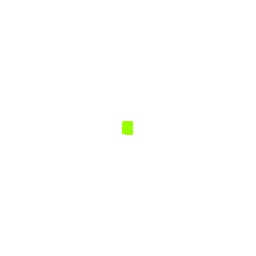

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 181/200
現在のマップ（中央部分）:


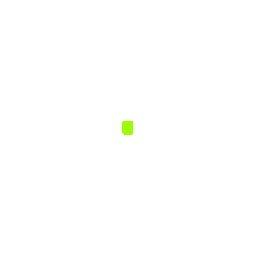

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 182/200
現在のマップ（中央部分）:


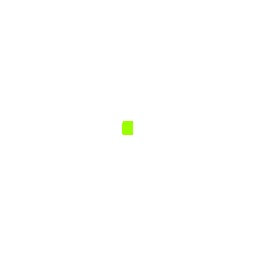

エポック:  91%|█████████ | 182/200 [00:06<00:00, 27.06it/s]

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 183/200
現在のマップ（中央部分）:


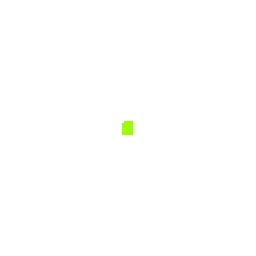

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 184/200
現在のマップ（中央部分）:


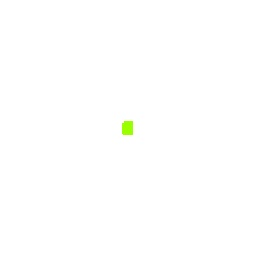

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 185/200
現在のマップ（中央部分）:


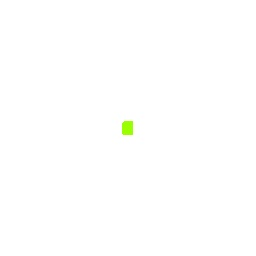

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 186/200
現在のマップ（中央部分）:


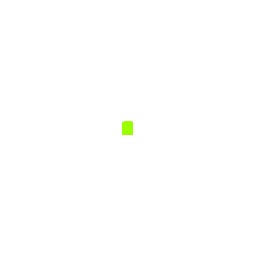

エポック:  93%|█████████▎| 186/200 [00:06<00:00, 28.46it/s]

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 187/200
現在のマップ（中央部分）:


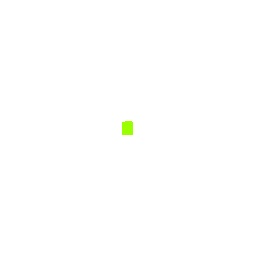

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 188/200
現在のマップ（中央部分）:


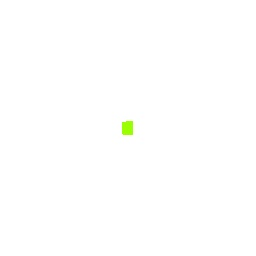

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 189/200
現在のマップ（中央部分）:


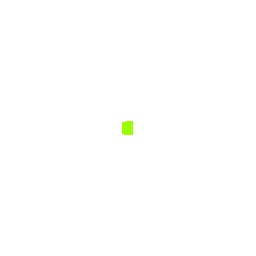

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 190/200
現在のマップ（中央部分）:


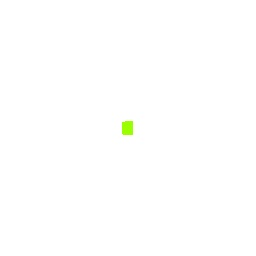

エポック:  95%|█████████▌| 190/200 [00:06<00:00, 29.18it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 191/200
現在のマップ（中央部分）:


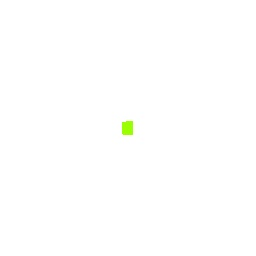

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 192/200
現在のマップ（中央部分）:


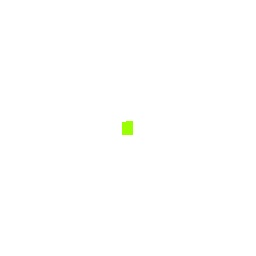

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 193/200
現在のマップ（中央部分）:


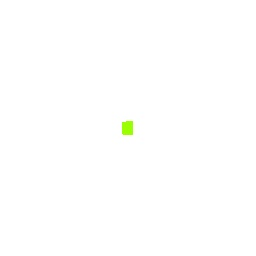

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 194/200
現在のマップ（中央部分）:


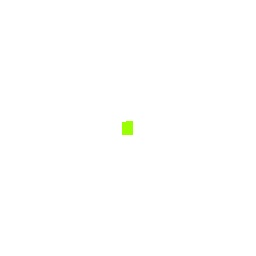

エポック:  97%|█████████▋| 194/200 [00:06<00:00, 30.44it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 195/200
現在のマップ（中央部分）:


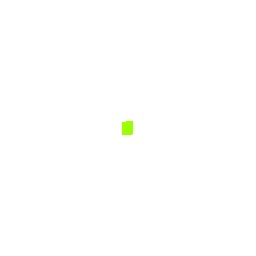

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 196/200
現在のマップ（中央部分）:


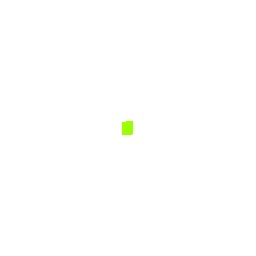

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 197/200
現在のマップ（中央部分）:


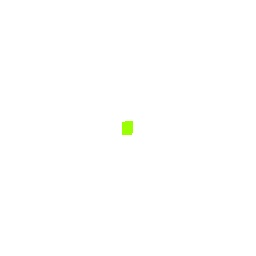

面積
tensor([65387.,   149.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 198/200
現在のマップ（中央部分）:


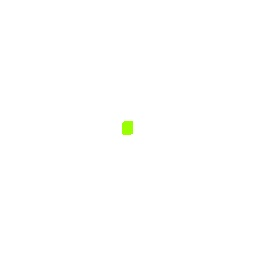

エポック:  99%|█████████▉| 198/200 [00:06<00:00, 31.30it/s]

面積
tensor([65388.,   148.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 199/200
現在のマップ（中央部分）:


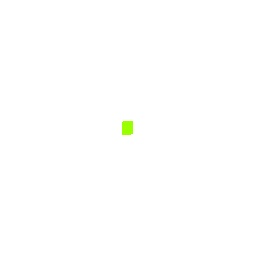

面積
tensor([65385.,   151.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False


エポック 200/200
現在のマップ（中央部分）:


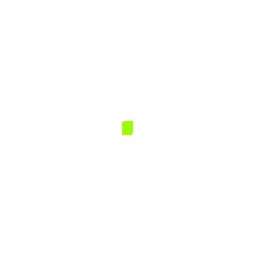

エポック: 100%|██████████| 200/200 [00:06<00:00, 30.34it/s]

面積
tensor([65386.,   150.], device='cuda:0')
周囲長
tensor([50., 50.], device='cuda:0')
False

最終状態のマップ:


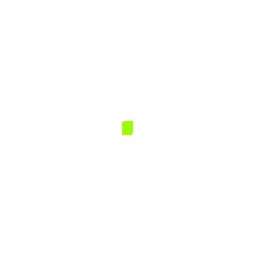


シミュレーション完了。


In [4]:
map_tensor = map_init(256,256) # マップを初期化
print("初期マップ（中央部分）:")
imshow_map(map_tensor) # 初期状態を表示

num_epochs = 200      # シミュレーションのエポック数
steps_per_epoch = 1 # 1エポックあたりのCPMステップ数
diffusion_steps = 5 # 1 CPMステップあたりの拡散ステップ数

# オプション: 動画記録用ライターの初期化
video_filename = 'cpm_torch_jp.mp4'
if moviepy_available:
    try:
        writer = LoopWriter(filename=video_filename, fps=10, fade_len=0.5) # ループ動画ライター
        print(f"動画を {video_filename} に記録します。")
        record_video = True
    except Exception as e:
        print(f"動画ライターの初期化に失敗しました: {e}")
        record_video = False
else:
    record_video = False
    print("moviepyが利用できないため、動画は記録されません。")

print("map shape ", map_tensor.shape) # マップの形状を表示
# --- シミュレーション実行 ---
for i in tqdm(range(num_epochs), desc="エポック"):
    for k in tqdm(range(steps_per_epoch), desc="CPMステップ", leave=False):

        # --- 拡散ステップ ---
        # 複数の拡散ステップを実行して密度を平滑化
        #for _ in range(diffusion_steps):
        #     map_tensor = diffusion_step(map_tensor, dt=0.1) # dtは拡散の速さ

        # --- CPM更新ステップ ---
        # チェッカーボードパターンで全セルを更新
        for x_offset in range(3): # x方向オフセット (0 or 1)
            for y_offset in range(3): # y方向オフセット (0 or 1)
                with torch.no_grad():
                  map_tensor, _ = cpm_checkerboard_step(map_tensor, l_A, A_0, l_L, L_0, T,
                                                      x_offset, y_offset)

        # 数値安定性のため、密度が負にならないようにクランプ
        map_tensor[:, :, 1].clamp_(min=0.0)

    # --- 各エポック終了時の可視化 ---
    #if ipython_available:
    #    clear_output(wait=True) # 出力をクリア
    print(f"エポック {i+1}/{num_epochs}")
    print("現在のマップ（中央部分）:")
    #imshow_map(map_tensor[100:150,100:150]) # IDに基づく色表示
    imshow_map(map_tensor)
    print_cpm_bins(map_tensor) # CPMのバイナリマップを表示
    # imshow_map_area_autoRange(map_tensor[100:156, 100:156, 1]) # 密度表示

    # デバッグ情報（コメントアウト）
    # density_vals = map_tensor[:, :, 1]
    # print(f"密度統計: 最大={density_vals.max().item():.2f}, 最小={density_vals.min().item():.2f}, 合計={density_vals.sum().item():.2f}")
    print(record_video)
    # --- 動画フレーム追加 ---
    if record_video:
        try:
            frame_rgb = map_tensor_to_rgb(map_tensor) # RGBフレームを取得
            # ライターにフレームを追加（imshowと同様、テンソルを直接渡せるようにヘルパー側で処理）
            writer.add(frame_rgb)
        except Exception as e:
            print(f"フレーム {i+1} の動画への追加中にエラー: {e}")
            record_video = False # エラーが発生したら記録を中止

# --- シミュレーション終了後 ---

# 動画ライターを閉じる
if record_video and writer:
    try:
        writer.close()
        print(f"動画を {video_filename} に保存しました。")
    except Exception as e:
        print(f"動画ライターのクローズ中にエラー: {e}")

# 最終状態を表示
print("\n最終状態のマップ:")
imshow_map(map_tensor)
# imshow_map_area_autoRange(map_tensor[:, :, 1])

print("\nシミュレーション完了。")

# --- END OF FILE CPM_torch_jp.py ---